<h1><center> Film Rating Prediction Project & Photo Reconstruction Project</center><h1>
<h2><center> Group Member 1:SONG XIAOHAN, A0191513L </center></h2>
<h2><center> Group Member 2:QIAN YUANYUAN, A0191552E </center></h2>
<h2><center> Group Member 3: OJJASVI PURI, A0191571A </center></h2>





## 项目简介：
1.	Film Rating Prediction Project：已有70775个用户对3314部电影1300万+条打分数据（部分），设计用户打分预测程序，预测数据缺失处的用户打分情况；
2.	Photo Reconstruction Project: 用BFGS算法为一噪声图片降噪。

In [1]:
from __future__ import division, print_function
from builtins import range

%matplotlib inline
import autograd.numpy as np
from autograd import grad
np.random.seed(123)
import time as time
import matplotlib.pyplot as plt
import pandas as pd
import os as os
from PIL import Image  

import scipy.optimize as scipy_optimize

<h1><center>Film Recommendation Project</center></h1>

### Data Dowload
Download the "rating_matrix.npy" on the IVLE. This file contains the $13$ millions of film ratings.


In [2]:
path = "C:\\Users\\Lenovo X240\\Documents\\opt"
data_netflix = np.load(os.path.join(path, "rating_matrix.npy"))


In [3]:
#first colum: USER_ID
#second colum: FILM_ID
#third colum: RATING_ID

print("USER_ID \t FILM_ID \t RATING")
print(data_netflix[:10])
print(data_netflix.shape)

USER_ID 	 FILM_ID 	 RATING
[[56210   138     3]
 [52985   120     3]
 [23195    64     4]
 [50206  1277     4]
 [29840   130     3]
 [59551    54     1]
 [66413    37     3]
 [32666    98     3]
 [69911     6     5]
 [28913    41     4]]
(13119291, 3)


In [4]:
n_users = len(np.unique(data_netflix[:,0]))
n_films = len(np.unique(data_netflix[:,1]))
n_ratings = len(data_netflix)
print("Total Number of Ratings = ", n_ratings)
print("Total Number of Users = ", n_users)
print("Total Number of Films = ", n_films)


Total Number of Ratings =  13119291
Total Number of Users =  70775
Total Number of Films =  3314


Text(0, 0.5, 'Proba')

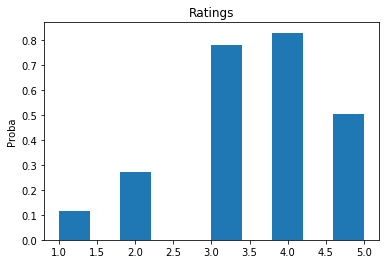

In [5]:
H = plt.hist(data_netflix[:,2], density=True)
plt.title("Ratings")
plt.ylabel("Proba")

In [6]:
#compute the number of ratings of each user
nb_rating_per_user = np.zeros(n_users)
nb_rating_per_film = np.zeros(n_films)
for k in range(n_ratings):
    user = data_netflix[k,0]
    film = data_netflix[k,1]
    nb_rating_per_user[user] += 1
    nb_rating_per_film[film] += 1

Text(0.5, 1.0, 'Number Ratings per Film')

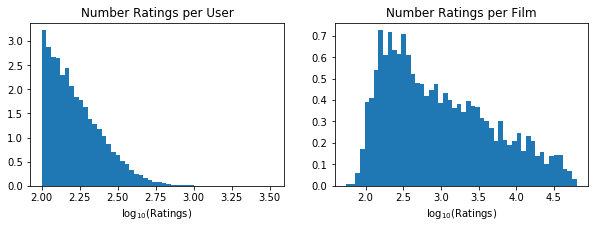

In [7]:
plt.rcParams['figure.figsize'] = (10,3)

plt.subplot(1,2,1)
H = plt.hist(np.log10(nb_rating_per_user), bins=50, density=True)
plt.xlabel(r"$\log_{10}$(Ratings)")
plt.title("Number Ratings per User")

plt.subplot(1,2,2)
H = plt.hist(np.log10(nb_rating_per_film), bins=50, density=True)
plt.xlabel(r"$\log_{10}$(Ratings)")
plt.title("Number Ratings per Film")


In [8]:
#split train / test data
n_train = int(n_ratings * 0.7)#70% for training
data_train = data_netflix[:n_train,:]
data_test = data_netflix[n_train:,:]


First column is the userId, the second column is the movieId, and the third column is the rating. Your task is to develop an algorithm that can predict the rating of a given user for a given film. You will train your algorithm on the training set "data_train" and test performances on the test set contained in "data_test".

In [9]:
def RMSE_predictions(true_ratings, predictions):
    return np.sqrt(np.mean( (true_ratings - predictions)**2 ))

Let us first look at the performaces of the most naive and useless prediction: a random prediction.

In [10]:
random_predictions = 1+np.random.random(size=len(data_test))
RMSE_random_predictions =  RMSE_predictions(data_test[:,2], random_predictions)
print("RMSE of random predictions = ", RMSE_random_predictions)

RMSE of random predictions =  2.3166966740325363


Let us now look at the performaces of a slightly less naive and but as useless prediction: the global average.

In [11]:
global_average = np.zeros(len(data_test)) + np.mean(data_train[:,2])
RMSE_global_average =  RMSE_predictions(data_test[:,2], global_average)
print("RMSE of global_average predictions = ", RMSE_global_average)

RMSE of global_average predictions =  1.0722443896110023


### Task:
Use the ideas introduced in chapter "Matrix Completion" to build a recommendation system that can predict the ratings of the data contained in "data_test". You can only use the data contained in "data_train" to fit your model. Report the RMSE of your predictions on the test-set.

First, we make sure that the users and films all appear in the training set.

In [15]:
n_users_train = len(np.unique(data_train[:,0]))
n_films_train = len(np.unique(data_train[:,1]))
n_ratings_train = len(data_train)
print("Total Number of Ratings in the training set = ", n_ratings_train)
print("Total Number of Users in the training set = ", n_users_train)
print("Total Number of Films in the training set = ", n_films_train)


Total Number of Ratings in the training set =  9183503
Total Number of Users in the training set =  70775
Total Number of Films in the training set =  3314


## First Trials: without Regularization

Our naive model is the global mean.

In [12]:
#initialize the M
M_naiv = np.mean(data_netflix[:n_train,2])
M_train = np.zeros(shape=[n_users,n_films])

The M_train here is the centered rating matrix of the training set.

In [13]:
#define M(centering)
for k in range(n_train):
    user = data_netflix[k,0]
    film = data_netflix[k,1]
    M_train[user,film]=data_netflix[k,2] - M_naiv

user_list_train and film_list_train contain indexes of users and films in the training set.

In [14]:
user_list_train = np.zeros(n_train,dtype=int)
film_list_train = np.zeros(n_train,dtype=int)
for k in range(n_train):
    user_list_train[k] = data_train[k,0]
    film_list_train[k] = data_train[k,1]

Here we define the loss function without regularization:
$$L(R)=\frac{1}{|J|}\sum_{u,f\in J} (\hat{R_{u,f}}-R_{u,f})^2$$

In [16]:
#loss function
llambda = 0.5
def L(U,V):
    diff=M_train-U @ V
    return np.sum((diff[user_list_train,film_list_train])**2)/n_train 


grad_U_L = grad(L, argnum=0)
grad_V_L = grad(L, argnum=1)


The basic gradient descent reads as follows:
$$U_{n+1} = U_n - \eta \, \nabla_U L(U_n, V_n)$$
$$V_{n+1} = V_n - \eta \, \nabla_V L(U_n, V_n)$$

In [17]:
#random initial guess 
p,q = M_train.shape
r = 10  #rank of the approximation
U_init = np.random.normal(0,1,size=(p,r))
V_init = np.random.normal(0,1,size=(r,q))


Here we use L-BFGS to minimize the loss function.

In [19]:
n_iter = 10
n_ter_BFGS = 10

U = np.copy(U_init)
V = np.copy(V_init)

loss_history = np.zeros(n_iter)

for k in range(n_iter):
    #update U with BFGS
    def L_V_fixed(U_flattenned):
        U = U_flattenned.reshape(p,r)
        return L(U,V)
    gradient_L_V_fixed = grad(L_V_fixed)
    output_BFGS = scipy_optimize.minimize(L_V_fixed,
                                          U.flatten(), #initial guess
                                          method='L-BFGS-B', 
                                          jac=gradient_L_V_fixed,
                                          tol = 10**-8,
                                          options={"maxiter":n_ter_BFGS})
    U = output_BFGS["x"].reshape(p,r)  #set U to the output of BFGS
    
    #update V with BFGS
    def L_U_fixed(V_flattenned):
        V = V_flattenned.reshape(r,q)
        return L(U,V)
    gradient_L_U_fixed = grad(L_U_fixed)
    output_BFGS = scipy_optimize.minimize(L_U_fixed,
                                          V.flatten(), #initial guess
                                          method='L-BFGS-B', 
                                          jac=gradient_L_U_fixed,
                                          tol = 10**-8,
                                          options={"maxiter":n_ter_BFGS})
    V = output_BFGS["x"].reshape(r,q)  #set U to the output of BFGS
    
    #keep track of loss
    loss_history[k] = L(U,V)
    print(k)

0
1
2
3
4
5
6
7
8
9


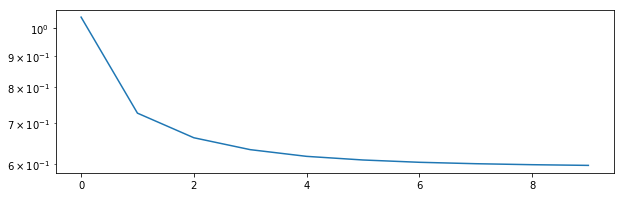

In [21]:
plt.plot(loss_history, "-")
plt.yscale("log")

In [25]:
np.savetxt('C:/Users/Lenovo X240/Documents/opt/assignment(u2.csv', U, delimiter = ',')
np.savetxt('C:/Users/Lenovo X240/Documents/opt/assignment(v2.csv', V, delimiter = ',')

In [26]:
M_out=U @ V

Then we create the test matrix.

In [27]:
#initialize the M_test
M_test = np.zeros(shape=[n_users,n_films])
M_test_true = np.zeros(shape=[n_users,n_films])

In [28]:
user_list_test = np.zeros(n_ratings-n_train,dtype=int)
film_list_test = np.zeros(n_ratings-n_train,dtype=int)
for k in range(n_ratings-n_train):
    user_list_test[k] = data_test[k,0]
    film_list_test[k] = data_test[k,1]

In [31]:
for k in range(n_train,len(data_netflix)):
    user = data_netflix[k,0]
    film = data_netflix[k,1]
    M_test_true[user,film]=data_netflix[k,2]-M_naiv 
    
for k in range(n_train,len(data_netflix)):
    user = data_netflix[k,0]
    film = data_netflix[k,1]
    M_test[user,film]=M_out[user,film]

Finally, using the loss function without regularization, the RMSE of our model is 0.848733193129539, which is better than the naive models.

In [32]:
RMSE_predictions(M_test[user_list_test,film_list_test], M_test_true[user_list_test,film_list_test])

0.8487433193129539

## Second Trials: with L1 Regularization

Here we define the loss function without regularization:
$$L(R)=\frac{1}{|J|}\sum_{u,f\in J} (\hat{R_{u,f}}-R_{u,f})^2+\frac{\lambda}{n_{users}}|U|_1+\frac{\lambda}{n_{films}}|V|_1$$

In [27]:
#loss function
llambda = 0.5
def L(U,V):
    diff=M_train-U @ V
    return np.sum((diff[user_list_train,film_list_train])**2)/n_train + llambda*np.sum(np.abs(U))/n_users + llambda*np.sum(np.abs(V))/n_films


grad_U_L = grad(L, argnum=0)
grad_V_L = grad(L, argnum=1)


The following is similar as above.

In [28]:
#random initial guess 
p,q = M_train.shape
r = 10  #rank of the approximation
U_init = np.random.normal(0,1,size=(p,r))
V_init = np.random.normal(0,1,size=(r,q))


In [31]:
n_iter = 10
n_ter_BFGS = 10

U = np.copy(U_init)
V = np.copy(V_init)

loss_history = np.zeros(n_iter)

for k in range(n_iter):
    #update U with BFGS
    def L_V_fixed(U_flattenned):
        U = U_flattenned.reshape(p,r)
        return L(U,V)
    gradient_L_V_fixed = grad(L_V_fixed)
    output_BFGS = scipy_optimize.minimize(L_V_fixed,
                                          U.flatten(), #initial guess
                                          method='L-BFGS-B', 
                                          jac=gradient_L_V_fixed,
                                          tol = 10**-8,
                                          options={"maxiter":n_ter_BFGS})
    U = output_BFGS["x"].reshape(p,r)  #set U to the output of BFGS
    
    #update V with BFGS
    def L_U_fixed(V_flattenned):
        V = V_flattenned.reshape(r,q)
        return L(U,V)
    gradient_L_U_fixed = grad(L_U_fixed)
    output_BFGS = scipy_optimize.minimize(L_U_fixed,
                                          V.flatten(), #initial guess
                                          method='L-BFGS-B', 
                                          jac=gradient_L_U_fixed,
                                          tol = 10**-8,
                                          options={"maxiter":n_ter_BFGS})
    V = output_BFGS["x"].reshape(r,q)  #set U to the output of BFGS
    
    #keep track of loss
    loss_history[k] = L(U,V)
    print(k)

0
1
2
3
4
5
6
7
8
9


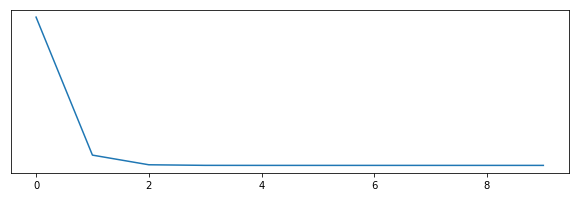

In [33]:
plt.plot(loss_history, "-")
plt.yscale("log")

In [34]:
np.savetxt('C:/Users/Lenovo X240/Documents/opt/assignment(u1.csv', U, delimiter = ',')
np.savetxt('C:/Users/Lenovo X240/Documents/opt/assignment(v1.csv', V, delimiter = ',')

In [35]:
M_out=U @ V

In [38]:
#initialize the M_test
M_test = np.zeros(shape=[n_users,n_films])
M_test_true = np.zeros(shape=[n_users,n_films])

In [43]:
user_list_test = np.zeros(n_ratings-n_train,dtype=int)
film_list_test = np.zeros(n_ratings-n_train,dtype=int)
for k in range(n_ratings-n_train):
    user_list_test[k] = data_test[k,0]
    film_list_test[k] = data_test[k,1]

In [44]:
for k in range(n_train,len(data_netflix)):
    user = data_netflix[k,0]
    film = data_netflix[k,1]
    M_test_true[user,film]=data_netflix[k,2]-M_naiv 
    
for k in range(n_train,len(data_netflix)):
    user = data_netflix[k,0]
    film = data_netflix[k,1]
    M_test[user,film]=M_out[user,film]

Here, we can see the RMSE of the model with L1 regularization is not better than the model without regularization.

In [45]:
RMSE_predictions(M_test[user_list_test,film_list_test], M_test_true[user_list_test,film_list_test])

1.0722513707666392

## First Trials: with L2 Regularization

Here we define the loss function without regularization:
$$L(R)=\frac{1}{|J|}\sum_{u,f\in J} (\hat{R_{u,f}}-R_{u,f})^2+\frac{\lambda}{n_{users}}||U||^2+\frac{\lambda}{n_{films}}||V||^2$$

In [16]:
global_average_train = np.zeros(len(data_train)) + np.mean(data_train[:,2])
residuals = data_train[:,2] - global_average_train

In [17]:
residual_matrix = np.zeros((n_users_train,n_films_train))
for k in range(n_ratings_train):
    user = data_train[k,0]
    film = data_train[k,1]
    residual_matrix[user,film] = residuals[k]

In [19]:
user_list_train = np.zeros(n_ratings_train,dtype=int)
film_list_train = np.zeros(n_ratings_train,dtype=int)
for k in range(n_ratings_train):
    user_list_train[k] = data_train[k,0]
    film_list_train[k] = data_train[k,1]

The loss function is definded as follows.

In [20]:
llambda = 1

def L(U,F):
    diff = residual_matrix - U @ F
    return np.sum((diff[user_list_train,film_list_train])**2)/n_ratings_train + llambda*np.sum(U**2)/n_users + llambda*np.sum(F**2)/n_films

grad_U_L = grad(L,argnum = 0)
grad_F_L = grad(L,argnum = 1)

In [21]:
p,q = 70775,3314
r = 10
U_init = np.random.normal(0,1,size = (p,r))
F_init = np.random.normal(0,1,size = (r,q))

In [23]:
n_iter = 10
n_ter_BFGS = 10

U = np.copy(U_init)
F = np.copy(F_init)

loss_history = np.zeros(n_iter)

for k in range(n_iter):
    #update U with BFGS
    def L_F_fixed(U_flattenned):
        U = U_flattenned.reshape(p,r)
        return L(U,F)
    gradient_L_F_fixed = grad(L_F_fixed)
    output_BFGS = scipy_optimize.minimize(L_F_fixed,
                                          U.flatten(), #initial guess
                                          method='L-BFGS-B', 
                                          jac=gradient_L_F_fixed,
                                          tol = 10**-8,
                                          options={"maxiter":n_ter_BFGS})
    U = output_BFGS["x"].reshape(p,r)  #set U to the output of BFGS
    
    #update V with BFGS
    def L_U_fixed(F_flattenned):
        F = F_flattenned.reshape(r,q)
        return L(U,F)
    gradient_L_U_fixed = grad(L_U_fixed)
    output_BFGS = scipy_optimize.minimize(L_U_fixed,
                                          F.flatten(), #initial guess
                                          method='L-BFGS-B', 
                                          jac=gradient_L_U_fixed,
                                          tol = 10**-8,
                                          options={"maxiter":n_ter_BFGS})
    F = output_BFGS["x"].reshape(r,q)  #set U to the output of BFGS
    
    #keep track of loss
    loss_history[k] = L(U,F)
    
    print(k)


0
1
2
3
4
5
6
7
8
9


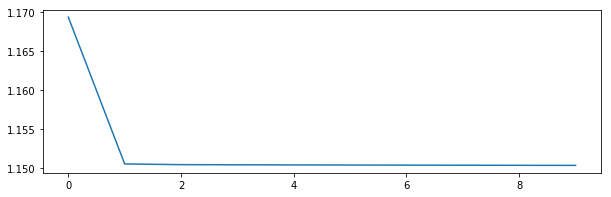

In [24]:
plt.plot(loss_history, "-")

In [25]:
np.savetxt('C:/Users/Lenovo X240/Documents/opt/assignmentUqian.csv', U, delimiter = ',')
np.savetxt('C:/Users/Lenovo X240/Documents/opt/assignmentFqian.csv', F, delimiter = ',')
np.savetxt('C:/Users/Lenovo X240/Documents/opt/assignmentlossqian.csv', loss_history, delimiter = ',')

In [26]:
prediction_matrix = U @ F + np.mean(data_test[:,2])

In [27]:
prediction = np.zeros(len(data_test))
for k in range(len(data_test)):
    prediction[k] = prediction_matrix[data_test[k,0],data_test[k,1]]

Here, we can see the RMSE of the model with L2 regularization is also not better than the model without regularization.

In [28]:
RMSE =  RMSE_predictions(data_test[:,2], prediction)
print("RMSE of predictions = ", RMSE)

RMSE of predictions =  1.0692811532953994


## Use different r value
In this section, we would like to see the effect ofthe r value.
Here, we dine a function, which input r, lambda and n_iteration and output loss history and rmse.

In [19]:
def predict(llambda, r, n_iter):
    def L(U,V):
        diff=M_train-U @ V
        return np.sum((diff[user_list_train,film_list_train])**2)/n_train + llambda*np.sum(U**2)/n_users + llambda*np.sum(V**2)/n_films

    grad_U_L = grad(L,argnum = 0)
    grad_V_L = grad(L,argnum = 1)
    
    p,q = 70775,3314
    U_init = np.random.normal(0,1,size = (p,r))
    V_init = np.random.normal(0,1,size = (r,q))
    
    n_ter_BFGS = 10

    U = np.copy(U_init)
    V = np.copy(V_init)

    loss_history = np.zeros(n_iter)

    for k in range(n_iter):
    #update U with BFGS
        def L_V_fixed(U_flattenned):
            U = U_flattenned.reshape(p,r)
            return L(U,V)
        gradient_L_V_fixed = grad(L_V_fixed)
        output_BFGS = scipy_optimize.minimize(L_V_fixed,
                                          U.flatten(), #initial guess
                                          method='L-BFGS-B', 
                                          jac=gradient_L_V_fixed,
                                          tol = 10**-8,
                                          options={"maxiter":n_ter_BFGS})
        U = output_BFGS["x"].reshape(p,r)  #set U to the output of BFGS
    
    #update V with BFGS
        def L_U_fixed(V_flattenned):
            V = V_flattenned.reshape(r,q)
            return L(U,V)
        gradient_L_U_fixed = grad(L_U_fixed)
        output_BFGS = scipy_optimize.minimize(L_U_fixed,
                                          V.flatten(), #initial guess
                                          method='L-BFGS-B', 
                                          jac=gradient_L_U_fixed,
                                          tol = 10**-8,
                                          options={"maxiter":n_ter_BFGS})
        V = output_BFGS["x"].reshape(r,q)  #set U to the output of BFGS
    
    #keep track of loss
        loss_history[k] = L(U,V)
    
    prediction_matrix = U @ V + np.mean(data_train[:,2])
    prediction = np.zeros(len(data_test))
    for k in range(len(data_test)):
        prediction[k] = prediction_matrix[data_test[k,0],data_test[k,1]]
        
    RMSE =  RMSE_predictions(data_test[:,2], prediction)
    return loss_history, RMSE

In [20]:
loss_history, RMSE=predict(llambda=0, r=5 , n_iter=10)

In [21]:
print(loss_history)
print(RMSE)

[1.07937899 0.76301734 0.70156685 0.68219659 0.67213231 0.66843757
 0.6668805  0.66623086 0.66585386 0.66558969]
0.8521438538545342


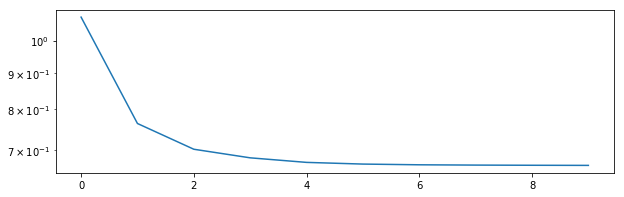

In [22]:
plt.plot(loss_history, "-")
plt.yscale("log")

In [18]:
loss_history, RMSE=predict(llambda=0, r=20 , n_iter=10)

In [19]:
print(loss_history)
print(RMSE)

[1.01324021 0.66471405 0.59694944 0.56649111 0.54873806 0.53737744
 0.53019559 0.52501813 0.52156854 0.51868638]
0.8937102199962562


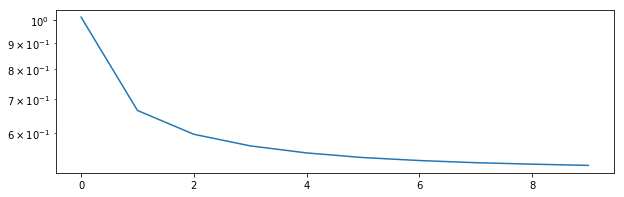

In [20]:
plt.plot(loss_history, "-")
plt.yscale("log")

In [18]:
loss_history, RMSE=predict(llambda=0, r=2 , n_iter=10)

In [20]:
print(loss_history)

[1.11160631 0.91063559 0.84471299 0.82136775 0.80283669 0.7867731
 0.77801116 0.77526727 0.77446376 0.77417406]


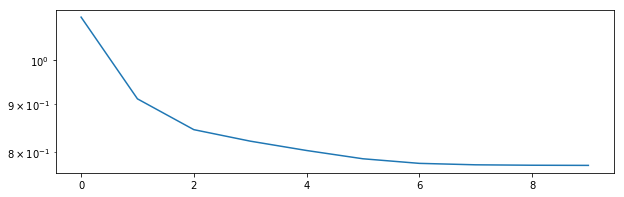

In [21]:
plt.plot(loss_history, "-")
plt.yscale("log")

In [27]:
print(RMSE)

0.8936028427557602

## Conclusion:
Compare the three results, we can see that the regulaization terms cannot make better results. So we finally choose the model without regularization. The best RMSE value we can get is about 0.85. Furthermore, we found that the higher r value won't necessarily result in a better RMSE. And the best r value among 2, 5, 10 and 20 is 10, according to the RMSE.

<h1><center>Image reconstruction project</center></h1>

This project consists in reconstructing an image from a noisy versoin of it. 
1. The original image, "NUS.png", can be thought of as a matrix $M$.
2. One only observes a noissy version of it, $N$, defined as
$$
N_{i,j} = \mathbf{Poisson}(M_{i,j}).
$$
3. Your task is to reconstruct a good approximation of the original image based only on the noisy version $N$ of it.

In [3]:
#load the data
path = "D:/Sem2 2018-2019/DSA4212/assignment2"
file = "NUS.png"

def read_image(path, file):
    """
    read an image, convert it to grayscale, normalize intensity pixels to (0,1)
    """
    img = np.array(Image.open(os.path.join(path, file)))
    return np.mean(img, axis=2) / 255.

In [4]:
#read the image
M = read_image(path, file)
print("Dimension of the Image:", M.shape)

Dimension of the Image: (182, 300)


In [5]:
#let us create a noisy version of it
N = np.random.poisson(M)

Text(0.5, 1.0, 'Noisy Image')

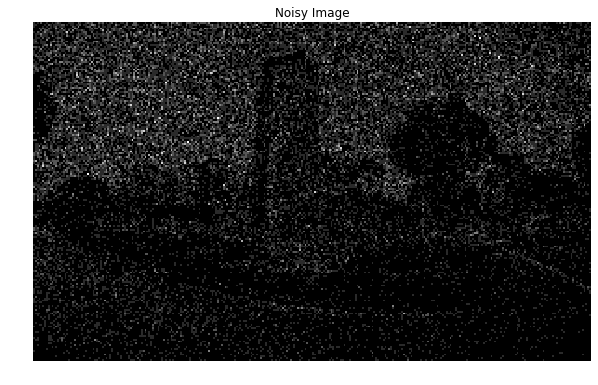

In [6]:
plt.rcParams['figure.figsize'] = (10,10)
plt.imshow(N, cmap = "gray")
plt.axis("off")
plt.title("Noisy Image")

For further operation, we first get the flattened version of N.

In [7]:
N_flatten = N.flatten()

### Remark:
x[:-1]: delete the last one element

x[:]: the whole object

x[1:]: delete the first element

Loss Function:
$$L(u) = \frac{1}{N}\sum (-y_i \, u_i + e^{u_i}) + \lambda \, \frac{1}{N} \sum \left( e^{u_{i+1}} - e^{u_i} \right)^2$$

In this part, we flatten the image, and calculate the loss function for the flattened array. And the regularization term here is only based on the flattened version.

In [8]:
def reconstruction(llambda,n_iteration):
    def loss(u):
        z = np.exp(u)
        return np.mean(-N_flatten*u + np.exp(u)) +llambda * np.mean((z[1:]-z[:-1])**2)

    grad_loss = grad(loss)
    
    u_init = np.random.normal(0,1,len(N_flatten))
    output_BFGS = scipy_optimize.minimize(loss,
                                      u_init, 
                                      method='L-BFGS-B', 
                                      jac=grad_loss,
                                      tol = 10**-8,
                                      options={"maxiter":n_iteration})
    u_final = output_BFGS["x"]
    z_final = np.exp(u_final)
    image_reconstructed = z_final.reshape(N.shape)
    return image_reconstructed,z_final

Text(0.5, 1.0, 'Reconstructed Image')

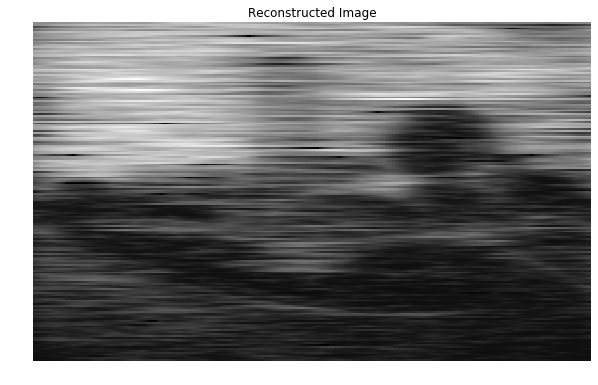

In [9]:
image_reconstructed, z_final = reconstruction(200,200)
plt.rcParams['figure.figsize'] = (10,10)
plt.imshow(image_reconstructed, cmap = "gray")
plt.axis("off")
plt.title("Reconstructed Image")

As we can see above, the outcome does not look good. Maybe it is because we shouldn not flatten the image.

After some research and trial, it turns out scipy_optimize can only run BFGS and L-BFGS on flattened array, so now we should think about how to flatten while keep the regularization term. Finally, we figure out the way: using reshape(). In the following section, we calculate the regularization term in both horizontal and vertical directions.

In [10]:
def reconstruction(llambda,n_iteration):
    def loss(u):
        z = np.exp(u)
        z = z.reshape(182,300)
        return np.mean(-N_flatten*u + np.exp(u)) +llambda *  (np.mean((z[1:,:]-z[:-1,:])**2) + np.mean((z[:,1:]-z[:,:-1])**2))

    grad_loss = grad(loss)
    
    u_init = np.random.normal(0,1,len(N_flatten))
    output_BFGS = scipy_optimize.minimize(loss,
                                      u_init, 
                                      method='L-BFGS-B', 
                                      jac=grad_loss,
                                      tol = 10**-8,
                                      options={"maxiter":n_iteration})
    u_final = output_BFGS["x"]
    z_final = np.exp(u_final)
    image_reconstructed = z_final.reshape(N.shape)
    return image_reconstructed,z_final

Text(0.5, 1.0, 'Reconstructed Image')

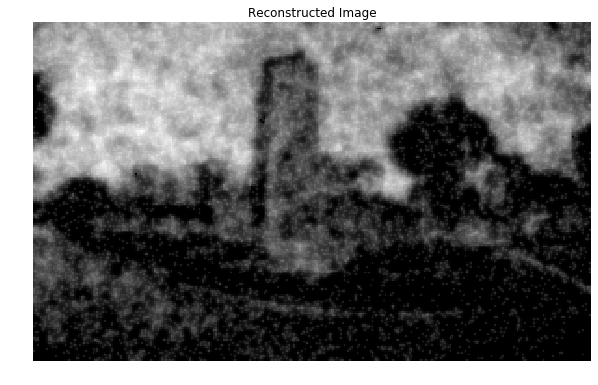

In [11]:
image_reconstructed, z_final = reconstruction(5,900)
plt.rcParams['figure.figsize'] = (10,10)
plt.imshow(image_reconstructed, cmap = "gray")
plt.axis("off")
plt.title("Reconstructed Image")

The outcome looks much better.

Then we would like to see the effect of lambda.

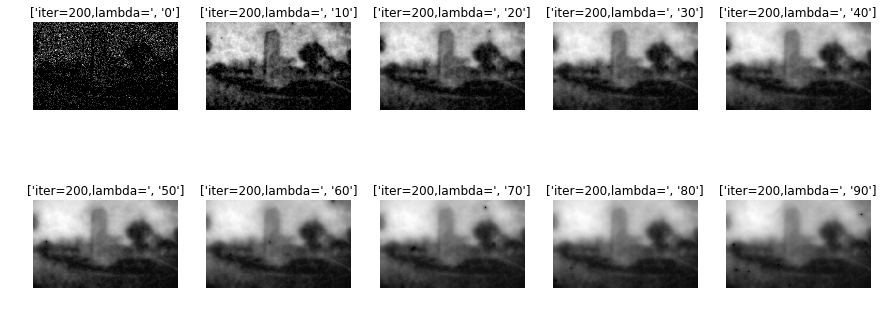

In [47]:
nrow, ncol = 2, 5
plt.rcParams['figure.figsize'] = (ncol*3, nrow*3) # Make the figures a bit bigger
for row in range(nrow):
    for col in range(ncol):
        img_index = row*ncol+col
        #img = read_image(path_to_img, img_index)
        llambda = 10*img_index
        #gender = data_gender[img_index]
        image_reconstructed, z_final = reconstruction(llambda,200)
        plt.subplot(nrow, ncol, img_index+1)
        plt.imshow(image_reconstructed, cmap="gray")
        title=['iter=200,lambda=',str(llambda)]
        plt.title(title)
        plt.axis('off')

It seems like that the lambda shouldn't be larger than 30. Let's try smaller lambda.

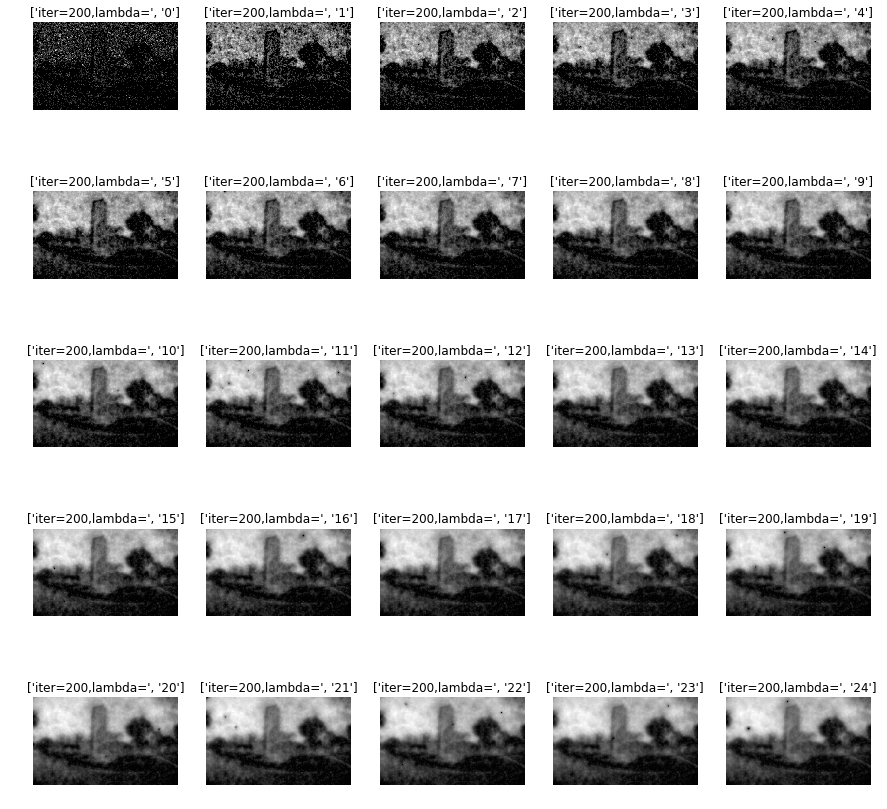

In [48]:
nrow, ncol = 5, 5
plt.rcParams['figure.figsize'] = (ncol*3, nrow*3) # Make the figures a bit bigger
for row in range(nrow):
    for col in range(ncol):
        img_index = row*ncol+col
        llambda = img_index
        image_reconstructed, z_final = reconstruction(llambda,200)
        plt.subplot(nrow, ncol, img_index+1)
        plt.imshow(image_reconstructed, cmap="gray")
        title=["iter=200,lambda=",str(llambda)]
        plt.title(title)
        plt.axis('off')

Then we would like to see the effect of the number of iteration.

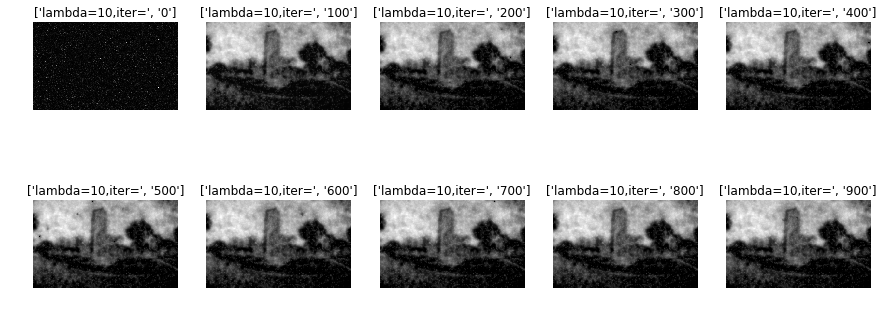

In [12]:
nrow, ncol = 2, 5
plt.rcParams['figure.figsize'] = (ncol*3, nrow*3) # Make the figures a bit bigger
for row in range(nrow):
    for col in range(ncol):
        img_index = row*ncol+col
        #img = read_image(path_to_img, img_index)
        n_iteration = 100*img_index
        #gender = data_gender[img_index]
        image_reconstructed, z_final = reconstruction(10,n_iteration)
        plt.subplot(nrow, ncol, img_index+1)
        plt.imshow(image_reconstructed, cmap="gray")
        title=["lambda=10,iter=",str(n_iteration)]
        plt.title(title)
        plt.axis('off')

## Conclusion:
Turns out 100 iterations is already enough. According to all the results we got from the former process, we set our tuning parameter as lambda=7. Here is the final reconstructed image.

Text(0.5, 1.0, 'Reconstructed Image')

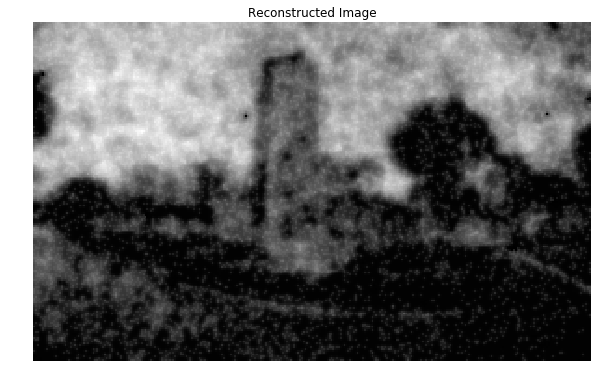

In [58]:
image_reconstructed, z_final = reconstruction(7,100)
plt.rcParams['figure.figsize'] = (10,10)
plt.imshow(image_reconstructed, cmap = "gray")
plt.axis("off")
plt.title("Reconstructed Image")

We also tried L1 regularization. But the results look worse, which is reasonable since the L1 regularizaton is not smooth.

In [53]:
def reconstruction_tv(llambda,n_iteration):
    def loss(u):
        z = np.exp(u)
        z = z.reshape(182,300)
        return np.mean(-N_flatten*u + np.exp(u)) +llambda *  (np.mean(abs(z[1:,:]-z[:-1,:])) + np.mean(abs(z[:,1:]-z[:,:-1])))

    grad_loss = grad(loss)
    
    u_init = np.random.normal(0,1,len(N_flatten))
    output_BFGS = scipy_optimize.minimize(loss,
                                      u_init, 
                                      method='L-BFGS-B', 
                                      jac=grad_loss,
                                      tol = 10**-8,
                                      options={"maxiter":n_iteration})
    u_final = output_BFGS["x"]
    z_final = np.exp(u_final)
    image_reconstructed = z_final.reshape(N.shape)
    return image_reconstructed,z_final

Text(0.5, 1.0, 'Reconstructed Image')

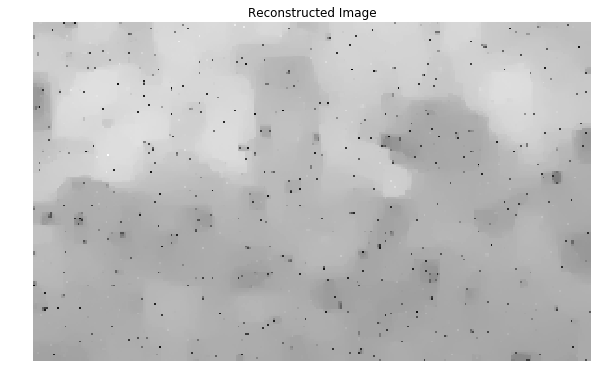

In [59]:
image_reconstructed, z_final = reconstruction_tv(7,100)
plt.rcParams['figure.figsize'] = (10,10)
plt.imshow(image_reconstructed, cmap = "gray")
plt.axis("off")
plt.title("Reconstructed Image")

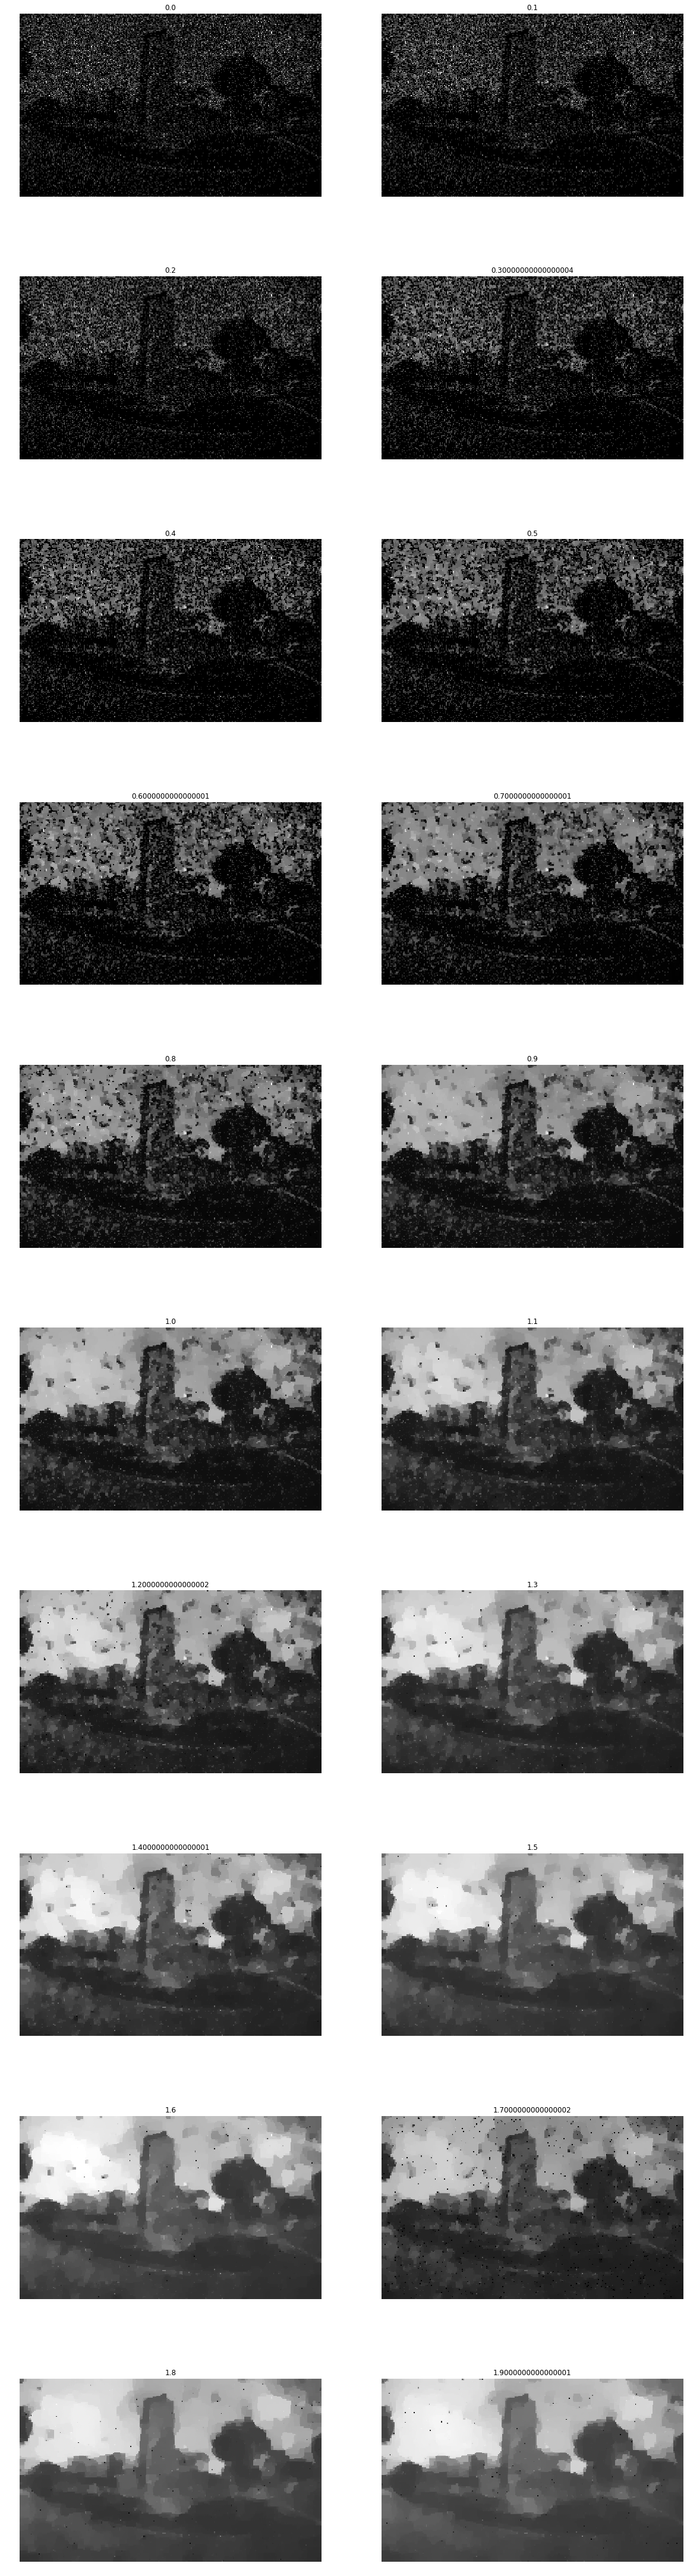

In [15]:
nrow, ncol = 10, 2
plt.rcParams['figure.figsize'] = (ncol*10, nrow*8) # Make the figures a bit bigger
for row in range(nrow):
    for col in range(ncol):
        img_index = row*ncol+col
        #img = read_image(path_to_img, img_index)
        llambda = img_index*0.1
        #gender = data_gender[img_index]
        image_reconstructed, z_final = reconstruction_tv(llambda,200)
        plt.subplot(nrow, ncol, img_index+1)
        plt.imshow(image_reconstructed, cmap="gray")
        plt.title(llambda)
        plt.axis('off')

So in this case, compared with L1 regularization, L2 regularization should be more suitable.